# Learning under Label Shift - 2D GMM, Softmax responses

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

First let's set the centroids of our two classes and the marginal distributions during training and testing. 

In [2]:
means = np.array([[1, 1], [-1, -1]])
variance = 1
py_train = [.5, .5]
py_test = [.2, .8]

In [3]:
num_train = 90000
num_valid = 1000
num_test = 1000
num_features = 2
num_classes = 2

In [4]:
X_train = np.zeros((num_train, num_features))
X_valid = np.zeros((num_valid, num_features))
X_test = nd.zeros((num_test, num_features))

Y_train = np.random.choice(num_classes, num_train, p=py_train)
Y_valid = np.random.choice(num_classes, num_valid, p=py_train)
Y_test = np.random.choice(num_classes, num_test, p=py_test)

In [5]:
for i in range(num_train):
    X_train[i] = np.random.multivariate_normal(means[Y_train[i]], np.identity(num_features))
    
for i in range(num_valid):
    X_valid[i] = np.random.multivariate_normal(means[Y_valid[i]], np.identity(num_features))
    
for i in range(num_test):
    X_test[i] = np.random.multivariate_normal(means[Y_test[i]], np.identity(num_features))

In [6]:
import matplotlib.pyplot as plt

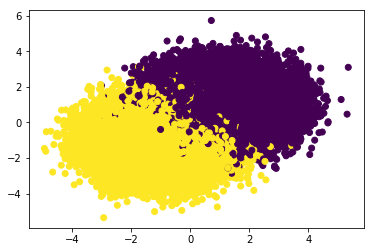

In [7]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.show()

## Now we'll train a simple logistic regression model to predict Y. 

In [8]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

net = gluon.nn.Dense(2)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

ce_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [9]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [10]:
batch_size = 1024

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_train), nd.array(Y_train)),
                                      batch_size=batch_size, shuffle=True)

valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_valid), nd.array(Y_valid)),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_test), nd.array(Y_test)),
                                      batch_size=batch_size, shuffle=True)


In [11]:
epochs = 30
loss_sequence = []

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = ce_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 51344.0898132
Epoch 1, loss: 30299.2406616
Epoch 2, loss: 24714.4514465
Epoch 3, loss: 22245.0562134
Epoch 4, loss: 20877.5514984
Epoch 5, loss: 20021.9857788
Epoch 6, loss: 19444.1730957
Epoch 7, loss: 19032.9965515
Epoch 8, loss: 18728.9894257
Epoch 9, loss: 18497.550705
Epoch 10, loss: 18317.1620026
Epoch 11, loss: 18173.8729401
Epoch 12, loss: 18058.4136505
Epoch 13, loss: 17964.0805054
Epoch 14, loss: 17886.2077637
Epoch 15, loss: 17821.291687
Epoch 16, loss: 17766.7202911
Epoch 17, loss: 17720.5460052
Epoch 18, loss: 17681.1991577
Epoch 19, loss: 17647.4347076
Epoch 20, loss: 17618.4706268
Epoch 21, loss: 17593.3827515
Epoch 22, loss: 17571.6606293
Epoch 23, loss: 17552.7084045
Epoch 24, loss: 17536.1431885
Epoch 25, loss: 17521.6685181
Epoch 26, loss: 17508.8874969
Epoch 27, loss: 17497.6882019
Epoch 28, loss: 17487.75914
Epoch 29, loss: 17479.0187683


## Now let's go through the valdiation set and put together the response matrix

In [12]:
response_matrix = nd.zeros((2,2))

In [13]:
valid_preds = nd.softmax(net(nd.array(X_valid)), axis=1)

In [14]:
nd.sum(valid_preds, axis=0)


[ 488.64175415  511.35824585]
<NDArray 2 @cpu(0)>

In [15]:
test_preds = nd.softmax(net(nd.array(X_test)), axis=1)

In [16]:
test_response = nd.sum(test_preds, axis=0) / num_test

In [17]:
test_response


[ 0.26727438  0.73272562]
<NDArray 2 @cpu(0)>

In [18]:
valid_preds


[[ 0.67886835  0.32113165]
 [ 0.00589147  0.99410856]
 [ 0.37573618  0.62426388]
 ..., 
 [ 0.00870641  0.99129361]
 [ 0.79514939  0.20485058]
 [ 0.14444414  0.85555583]]
<NDArray 1000x2 @cpu(0)>

### Building the reponse matrix

Now we will build the response matric based on the classifier's output on the validation set. 

In [19]:
YV = nd.array(Y_valid)
valid_counts = nd.zeros(num_classes)

for i in range(num_valid):
    response_matrix[:,int(Y_valid[i])] += valid_preds[i] 
    valid_counts[int(Y_valid[i])] += 1

In [20]:
for j in range(num_classes):
    if valid_counts[j] > 0:
        response_matrix[:,j] /= valid_counts[j]

In [21]:
response_matrix


[[ 0.85986954  0.12766461]
 [ 0.14013031  0.87233531]]
<NDArray 2x2 @cpu(0)>

## Invert the response matrix and estimate the test set marginal P(Y)

In [22]:
R_inv = np.linalg.inv(response_matrix.asnumpy())

In [23]:
R_inv.dot(test_response.asnumpy())

array([ 0.19067034,  0.80932975], dtype=float32)